### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os
import pdfplumber
import shutil
import glob
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
import math
import random

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)

# Defining

Code for ProtBERT and BFD

In [24]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

2023-02-14 13:57:07.788421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 13:57:07.789365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [ ]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

In [ ]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [ ]:
average_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(2, 9)


In [ ]:
tf.__version__

'2.10.0'

# Data Formatting

In [ ]:
# Read GenBank and UniProt
dummy = []
head = []
flag = False
with open("../Data/Dengue/genbank.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        if flag == True:
            flag = False
            continue
        if i.find("light") != -1:
            flag = True
            continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 300) & (len(i) >= 120):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
dengue_sequences = head

textual_sequences = list(dict.fromkeys(dengue_sequences))

['EVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCAVGLPVDYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSC\n', 'SEIVLTQSPATLSLSPGERATLSCRASQSISTFLAWYQHKPGQAPRLLIYDASTRATGVPARFSGSRSGTDFTLTISTLEPEDFAVYYCQQRYNWPPYTFGQGTKVEIKAAADDDDKAGWSHPQFEKGGGSGGGSGGGSWSHPQFEK\n', 'EVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVAVISYDGSNKYYADSVKGRFTISRDNSKSTLYLQMNNLRAEDTAVYYCARDHLGWSSIWSAPESFLDYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEPK\n', 'EVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCAVGLPVDYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEP\n', 'EIVLTQSPATLSLSPGQRATLSCRASQSVSNYFAWYQQKPGQAPRLLIYDTSKRATGTPARFSGSGSGTDFTLTISSLEPEDFAVYYCQERNNWPLTWTFGLGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVT

In [ ]:
# Read JSAV
df = pd.read_csv("../Data/Dengue/JSAV_Export.csv", skiprows=1)
df.drop(df.columns[[0, 1, 2, 3, 4, 5]], axis=1, inplace=True)
df.drop(["H35A", "H35B", "H52A", "H82A", "H82B", "H82C", "H100A", "H100B", "H100C", "H100D", "H100E", "H100F", "H100G", "H100H", "H100I", "H100J"], axis=1, inplace=True)
array = df.to_string(header=False, index=False, index_names=False).split('\n')
jsav_sequences = []
for i in array:
    if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
        i = i.replace(" ", "")
        print(i)
        jsav_sequences.append(i)

EVQLQESGPELARPGASVKLSCKASGYGFTNCLIDWVKQSPGRGLEWMGMVNSNGDTCYHEKFKDKANLAAEKSSSTAYMQFQSEDPAVYFCARRVPYYRDYWGQGTTVTVSS
QVQLQQSGAELVRPGTSVKVSCKASGYAFTNYLIEWVMQRPGQGLEWIGVINGSGDTYYNEKFKEKAAPAADKSSSTAYMQLTSEDSAVYFCARGDLTYYDYWGQGTTVTVSS
EVQLQQSGAELVRPGASVKVSCKASGYAFTGYLIEWVMQRPGQGLEWIGVINGSGDTYHKEKFKAKTTLTADKSSSTAYMQLTSEDSAVYFCARGDLTYYDYWGQGTTVTVSS
QVKLQQSGADLVRPGASVKLSCKASGYAFTSYLIEWVMQRPGQGLEWIGVIISSGDTTYDEKFKGKATMTADKSSSTAYMQLTSEDSAVYFCARRGTTLLDYWGQGTTVTVSS
QIQLVQSGPELKKPGETVKISCKASGYTFTDYSMHWVKQAPGKGLKWMGWFNETGEPTYADDFKGRFAFSLETSASTAFLQIKNEDTATYFCARGGDFYSDYWGQGTSVTVSS
QIQLVQSGPELKKPGETVKISCKASGYTFTDYSMHWVKQTPGKGLKWLGWINKTGEPTYVDDFKGRFAFYLETSSSTAYLQIKNEDTATYFCARGYDYYSDYWGQGTLVTVSS
QVQLKESGPGLVAPSQSLSITCTVSGFSLTSYGVDWVRQSPGKGLEWLGVIWGAGSTNYNSAFRSRLSISKDNSKSQVFLKMQTDDTAMYYCASGTGTGADYWGQGTSVTVSS
EVQVQQSGPELVTPGASVKISCKTSGYTFTEYTVHWVKQSHGKSLEWIGGINTSGGTNYNQRFRGKATLTVDRSSSTAYMELTSEDSAVYFCAGTLYGYPDFWGQGTTLTVSS
QVTLKESGPGILQSSQTLSLTCSFSGFSLSTSSMGWIRQPSGKGLEWLAHIYWDDDKRYSPSLKSRLTISKDTSRNQVFLKIENVDSA

In [ ]:
# Read PDB's
pdb_sequences = []
stem = "../Data/Dengue/PDB/"
# filelist = os.listdir("../Data/Dengue/PDB/")
# filelist.remove(".DS_Store")
# for i in filelist:
#     shutil.copy(stem + i, stem + i.split(".")[-2] + ".txt")

filelist = glob.glob(stem + '*.txt')
for i in filelist:
    with open(i) as myfile:
        flag = False
        for j in myfile:
            if flag == True:
                pdb_sequences.append(j)
                flag = False
                continue
            if " " not in j.strip():
                continue
            if j.find("Heavy") != -1 or j.find("heavy") != -1:
                print(j)
                flag = True
                continue
            if re.search('Domain', j, re.IGNORECASE) or re.search('POLYPROTEIN', j, re.IGNORECASE) or re.search('PrM', j, re.IGNORECASE) or re.search('premembrane', j, re.IGNORECASE) or re.search('non-structural', j, re.IGNORECASE) or re.search('ectodomain', j, re.IGNORECASE) or re.search('glycoprotein', j, re.IGNORECASE) or re.search('envelope protein', j, re.IGNORECASE) or re.search('kappa', j, re.IGNORECASE) or re.search('lambda', j, re.IGNORECASE) or re.search('light', j, re.IGNORECASE):
                continue
            else:
                print(j)
                flag = True
print(pdb_sequences)

>3I50_3|Chain C[auth H]|murine heavy chain (IgG3) of E53 monoclonal antibody Fab|Mus musculus (10090)

>4AL8_2|Chain B[auth H]|FAB 2H12 HEAVY CHAIN|HOMO SAPIENS (9606)

>4UIH_2|Chains D, F|ANTIGEN-BINDING FRAGMENT OF HUMAN ANTIBODY 2D22 -HEAVY CHAIN|HOMO SAPIENS (9606)

>4FFY_2|Chain B[auth H]|DENV1-E111 single chain variable fragment (heavy chain)|Mus musculus (10090)

>6IDI_3|Chains G[auth H], H[auth I], K[auth M]|Fab 1H10 heavy chain (V-region)|Homo sapiens (9606)

>3UC0_2|Chains C[auth H], D[auth I]|Heavy chain, monoclonal antibody 5H2|Pan troglodytes (9598)

>3UZQ_1|Chain A|anti-dengue Mab 4E11|Mus musculus (10090)

>4BZ1_2|Chain B[auth H]|FAB 3E31 HEAVY CHAIN|MUS MUSCULUS (10090)

>7K93_2|Chains E, F[auth G], G[auth I], H[auth K]|2B7 single chain fab variable region|Mus musculus (10090)

>4UTA_2|Chains C[auth H], D[auth I]|BROADLY NEUTRALIZING HUMAN ANTIBODY EDE1 C8 HEAVY CHAIN|HOMO SAPIENS (9606)

>3J8D_2|Chains B[auth A], C[auth D]|antibody E111 Fab fragment|Mus musculus (10090

In [ ]:
# need mass filtering, making sure between 100 and 138

dengue_sequences = np.concatenate((textual_sequences, jsav_sequences, pdb_sequences))

dengue_sequences = list(dict.fromkeys(dengue_sequences))
print(len(dengue_sequences))
dengue_sequences = [i for i in dengue_sequences if len(i) >= 120]
print(len(dengue_sequences))
dengue_sequences = [i for i in dengue_sequences if len(i) <= 300]
print(len(dengue_sequences))
dengue_sequences = [i for i in dengue_sequences if i.find("X") == -1 if i.find("-") == -1]
print(len(dengue_sequences))
np.random.shuffle(dengue_sequences)

108
95
94
94


In [ ]:
# shutil.copy("../Data/dengue/heavy_seqs_aa.fasta", "../Data/dengue/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

In [ ]:
dummy = []
head = []

with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1 & i.find("E") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for dengue, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 300) & (len(aa_sequence) >= 120):
                head.append(aa_sequence)
                if len(head) >= 3000:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVESGGGLVKPGGSLRLSCAASGFTFSDYSMNWVRQAPGKGLEWVSSISTGSSSYIYYADSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAREERNNWNDFGEHYFDYWGQGTLVTVSS', 'EAQLVQSGAEVKKPGESLKISCKASGYFFSSYWIGWVRQMPGKGLEWMGIIYPGDSDTRYSPSFQGQVTISADKSINTAYLQWSSLEASDTAMYYCARRGGANNYGYDYWGQGSLVTVSS', 'QVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLEWMGWINPNSGGTNYAQKFQGRVTMTRDTSISTAYMELSRLRSDDTAVYYCARLPGGYIAAQPNDAFDIWGQGTMVTVSS', 'QVQLVQSGAEVKKPGASVRVSCKASGYTFSGHYMHWVRQAPGQGLEWMGRINPHSGDTHYAQKFQGRVTMTRDTSIDTAYLELSRLRSDDTAVYYCARTWIQLWTPDFDFWGQGTSVTVSS', 'EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKALQSVVTHEYYFDYWGQGTLVTVSS'] 3000


In [ ]:
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(dengue_sequences, key=len)))
print(len(healthy_sequences))
print(len(dengue_sequences))
# print(dengue_sequences)

139
284
3000
94


In [ ]:
del head
del myfile
del dummy
gc.collect()

0

In [ ]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [ ]:
if os.path.exists('dengue_binary_embeddings') == False:
    os.mkdir('dengue_binary_embeddings')

In [ ]:
number_param_dengue = math.ceil(len(dengue_sequences)/3000)

for i in range(number_param_dengue):
    dengue_sequences_new = [(" ".join(s)) for s in dengue_sequences][round(len(dengue_sequences) * (1/number_param_dengue) * i):round(len(dengue_sequences) * (1/number_param_dengue) * (i+1))]
    dengue_average_embeddings = get_embeddings(dengue_sequences_new)

    with open("dengue_binary_embeddings/dengue_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(dengue_average_embeddings, f)

    del dengue_sequences_new
    del dengue_average_embeddings
    gc.collect()

(94, 285)


In [ ]:
number_param_healthy = math.ceil(len(healthy_sequences)/3000)

for i in range(number_param_healthy):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * (1/number_param_healthy) * i):round(len(healthy_sequences) * (1/number_param_healthy) * (i+1))]
    healthy_average_embeddings = get_embeddings(healthy_sequences_new)

    with open("dengue_binary_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(healthy_average_embeddings, f)
    f.close()

    del healthy_sequences_new
    del healthy_average_embeddings
    gc.collect()

(3000, 141)


# Loading

In [2]:
dengue_average_embeddings = [[None] * 1024]

In [3]:
number_param_dengue = 1
for i in range(number_param_dengue):
    with open("dengue_binary_embeddings/dengue_" + str(i) + ".pkl", "rb") as f:
        dengue_temp = pickle.load(f)
        dengue_average_embeddings = np.concatenate((dengue_average_embeddings, dengue_temp))
    f.close()

dengue_average_embeddings = np.delete(dengue_average_embeddings, 0, 0)

In [4]:
healthy_average_embeddings = [[None] * 1024]

In [5]:
number_param_healthy = 1
for i in range(number_param_healthy):
    with open("dengue_binary_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [6]:
print(healthy_average_embeddings.shape)

(3000, 1024)


In [7]:
healthy_lables = [0] * 94 # 350
dengue_lables = [1] * 94

# Visualization

In [12]:
from sklearn.manifold import TSNE
embeds = np.concatenate((dengue_average_embeddings, healthy_average_embeddings[:1000]))

In [13]:
%%time

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10)
X_embedded = tsne.fit_transform(embeds)

CPU times: user 7.79 s, sys: 1.43 s, total: 9.23 s
Wall time: 2.68 s


In [14]:
# all_sequences = np.concatenate((dengue_sequences, healthy_sequences[:1000]))
disease_labels = ['Dengue'] * 94 + ['Healthy'] * 1000

In [15]:
df = pd.DataFrame()
df.insert(0, 't-SNE 1', X_embedded[:,0])
df.insert(1, 't-SNE 2', X_embedded[:,1])
# df.insert(2, 'Sequence', all_sequences)
df.insert(2, 'Disease Label', disease_labels)
df

,t-SNE 1,t-SNE 2,Disease Label
0,-48.674221,-1.833316,Dengue
1,34.189125,29.444729,Dengue
2,33.940266,30.211956,Dengue
3,30.305969,30.155098,Dengue
4,-48.779301,-1.930562,Dengue
...,...,...,...
1089,-19.278452,-30.642015,Healthy
1090,30.631296,-19.036987,Healthy
1091,4.741791,15.812238,Healthy
1092,41.310841,-7.535972,Healthy


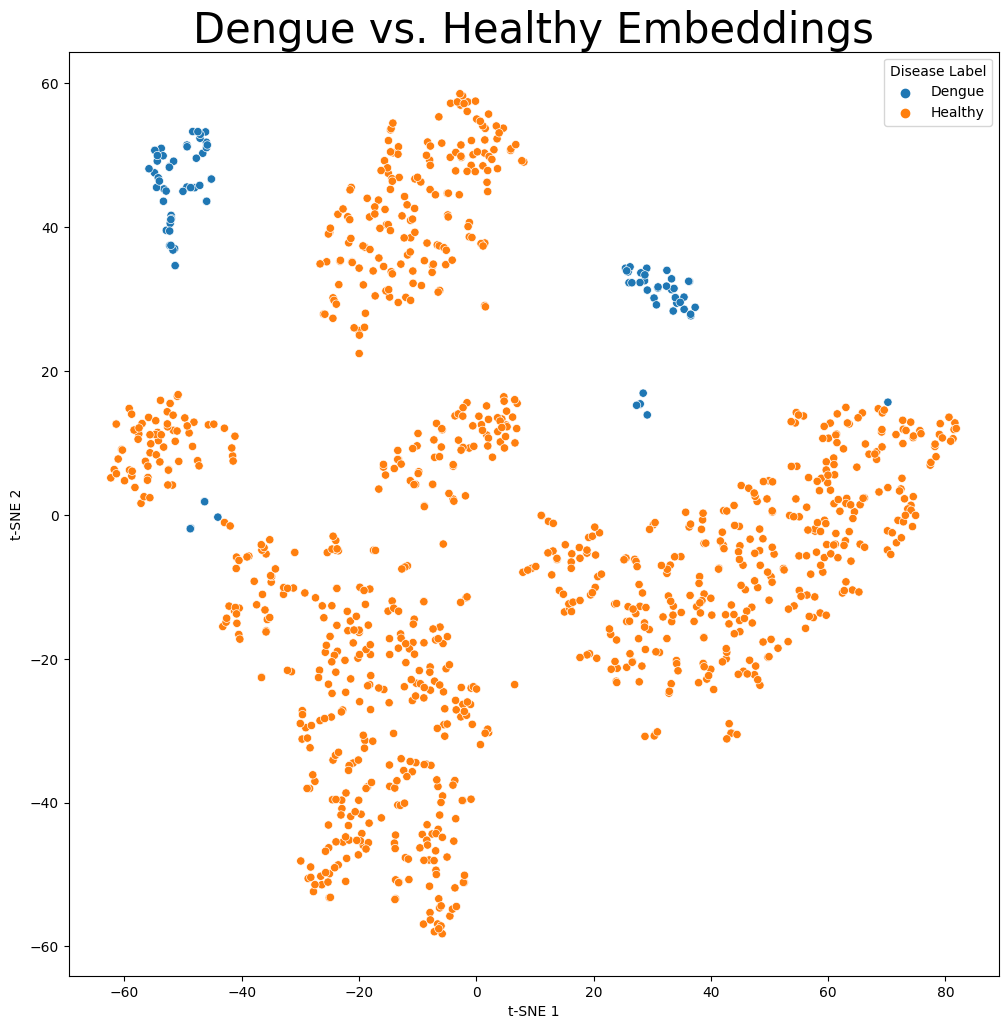

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue="Disease Label",
    data=df,
    legend="full"
)
plt.title("Dengue vs. Healthy Embeddings", fontsize=30)
plt.show()

# Model 3: Averaging Embeddings

In [17]:
X = np.concatenate((healthy_average_embeddings[:94], dengue_average_embeddings))
y = np.concatenate((healthy_lables, dengue_lables))

In [18]:
del dengue_average_embeddings
gc.collect()

835

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(len(X_train))
print(len(X_test))

150
38


In [21]:
print(len([i for i in y_test if i == 0]))
print(len([i for i in y_test if i == 1]))

19
19


In [22]:
# val_set = zip(X_val, y_val)
# new_y_val = []
# new_X_val = []
# count = 0
# for i in val_set:
#     if i[1] == 1:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#     if i[1] == 0 and count < 11:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#         count+=1

# c = list(zip(new_X_val, new_y_val))

# random.shuffle(c)

# X_val, y_val = zip(*c)
# y_val = np.array(y_val)
# print(y_val)

In [23]:
# test_set = zip(X_test, y_test)
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 15:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# print(y_test)

In [24]:
# Don't run this stuff! Ignore SMOTE!

In [25]:
X_train = np.concatenate((X_train, healthy_average_embeddings[94:1000]))
y_train = np.concatenate((y_train, [0] * len(healthy_average_embeddings[94:1000])))

In [26]:
for i in y_train:
    print(i)

0
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
1
0
0
1
1
1
0
0
0
1
0
1
0
1
0
1
0
1
1
1
0
1
1
0
0
1
0
0
1
1
1
1
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
1
0
0
1
0
0
0
0
1
0
0
1
1
0
1
1
1
0
0
0
0
1
1
0
1
1
0
1
0
1
1
0
0
0
0
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
1
0
1
0
0
0
0
0
1
1
1
0
1
1
0
0
1
1
1
1
1
1
0
0
1
1
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [27]:
del X
del healthy_average_embeddings
del y
gc.collect()

4081

### Using SMOTE

In [28]:
# print(len([i for i in y_train if i == 0]))
# sm = SMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

### Using Borderline SMOTE

In [29]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

In [30]:
for i in y_train:
    print(i)

0
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
1
0
0
1
1
1
0
0
0
1
0
1
0
1
0
1
0
1
1
1
0
1
1
0
0
1
0
0
1
1
1
1
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
1
0
0
1
0
0
0
0
1
0
0
1
1
0
1
1
1
0
0
0
0
1
1
0
1
1
0
1
0
1
1
0
0
0
0
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
0
1
0
1
0
0
0
0
0
1
1
1
0
1
1
0
0
1
1
1
1
1
1
0
0
1
1
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [31]:
c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
y_train = np.array(y_train)
for i in y_train:
    print(i)

0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0


### Model Evaluation

In [32]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [33]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-14 13:58:16.775291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 13:58:16.775497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                                                 
 dense_4 (Dense)             (None, 256)               9

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [35]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

In [36]:
# With SMOTE
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_test, y_test), callbacks=[es])

Epoch 1/100


2023-02-14 13:58:18.975986: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 13:58:19.322904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/33 [===========================>..] - ETA: 0s - loss: 0.2754 - accuracy: 0.9294

2023-02-14 13:58:21.563290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 3s 27ms/step - loss: 0.2642 - accuracy: 0.9280 - val_loss: 0.4267 - val_accuracy: 0.5000
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0615 - accuracy: 0.9290 - val_loss: 0.3483 - val_accuracy: 0.5000
Epoch 3/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0536 - accuracy: 0.9792 - val_loss: 0.2904 - val_accuracy: 1.0000
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 6.8878e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 1.3858e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 3.5290e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accurac

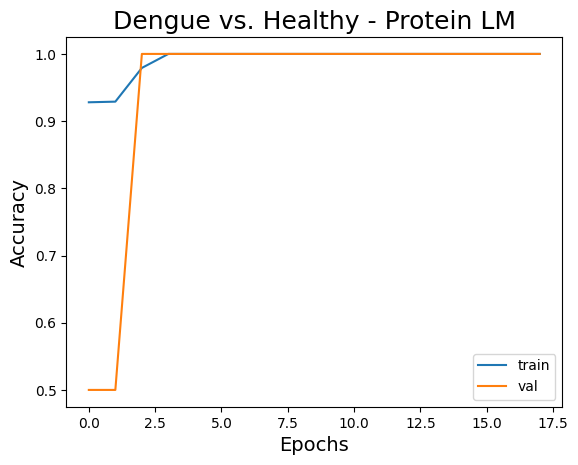

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dengue vs. Healthy - Protein LM', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.yticks(np.arange(0.75, 1.0, 0.02))
# plt.xticks(np.arange(0, 20, 1.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [23]:
model.save("dengue_model.h5")

In [18]:
model.evaluate(X_test, y_test)

2023-02-02 21:41:14.684652: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 21:41:14.770359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 81ms/step - loss: 0.3797 - accuracy: 0.7895


[0.3797115385532379, 0.7894737124443054]

In [15]:
model = tf.keras.models.load_model("dengue_model.h5")

2023-02-02 21:41:01.034491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 21:41:01.034707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [33]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-26 11:51:16.039779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32)]

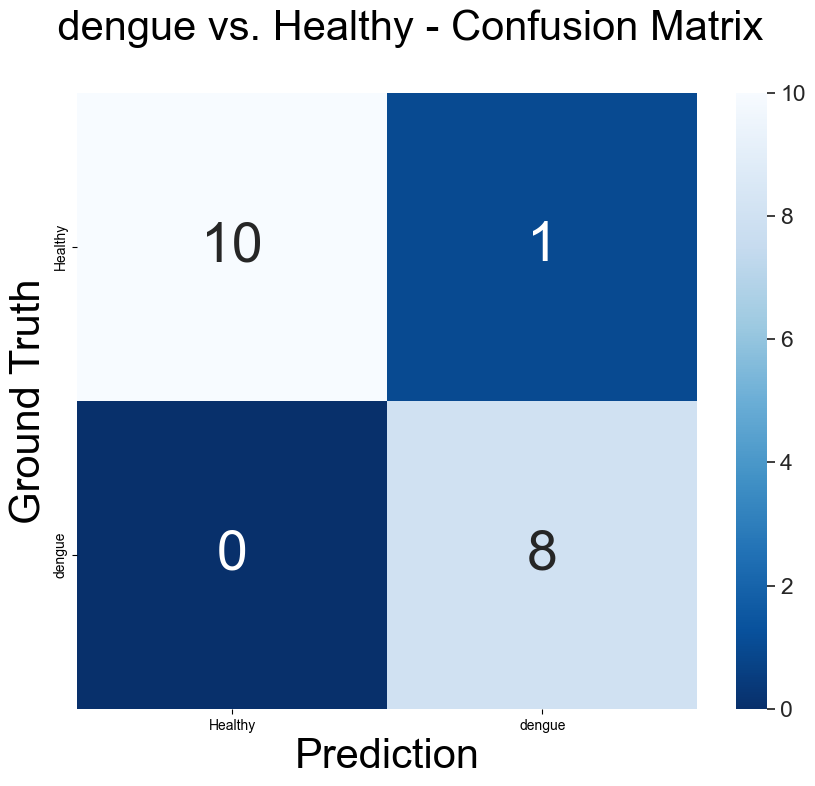

tf.Tensor(
[[10  1]
 [ 0  8]], shape=(2, 2), dtype=int32)


In [34]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    dengue vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "dengue"],
            yticklabels=["Healthy", "dengue"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [35]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

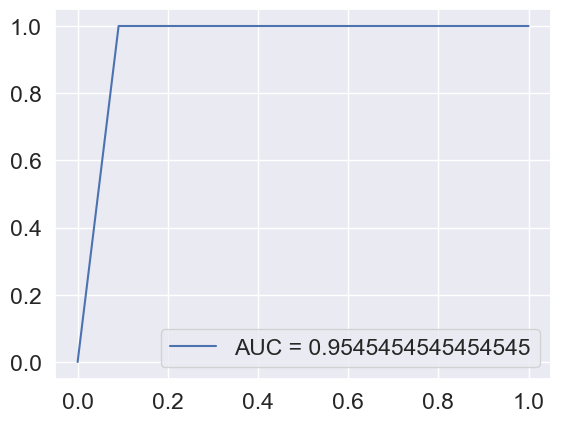

In [36]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()